In [ ]:
import numpy as np
import math
from astropy.cosmology import Planck18 as cosmo
import os 
import scipy
from matplotlib import pyplot as plt 
from matplotlib import font_manager
os.chdir('/home/hoelsczj/Documents/Cosmology/Hubble_Tension')

"""
Sets the initial conditions (densities at recombination)
"""

def InitialConditions(h, FractionA):
    #Constants
    c = 299792458          #m/s
    G = 6.67430e-11       #m^3 kg^-1 s^-2
    MetersPerMpc = 3.086e22  #meters per Mpc
    z_rec = 1090          #Redshift at recombination

    H0 = 100*h           #km/s/Mpc
    H0_SI = H0*1000/MetersPerMpc  # s^-1
    rho_crit_0 = 3*(H0_SI**2)/(8*np.pi*G)  #Critical density today, kg/m^3
    Omega_r = 4.15e-5/(h**2)  #Radiation density parameter (photons + neutrinos), from Dodelson 
    Omega_matter_total = 0.14241/(h**2)
    Omega_EDM = Omega_matter_total*0.85*FractionA #We assume that dark matter is 85 percent of total matter density, and FractionA gives fraction of dark matter in cascade  
    Omega_m = Omega_matter_total - Omega_EDM #Matter that is not EDM
    Omega_Lambda = 1.0 - Omega_m - Omega_EDM - Omega_r #Dark energy density for flatness 

    #Density parameters at z=1090
    rho_EDM_initial = Omega_EDM*rho_crit_0*((1 + z_rec)**3)  #Total exotic dark matter density (the cascade fields A and B)
    rho_m_initial = Omega_m*rho_crit_0*((1 + z_rec)**3)  #Total (non-exotic dark matter) matter density
    rho_r_initial = Omega_r*rho_crit_0*((1 + z_rec)**4)  #Radiation density
    rho_Lambda_initial = Omega_Lambda*rho_crit_0  #Dark energy density, is constant with redshift 
    return rho_EDM_initial, rho_m_initial, rho_r_initial, rho_Lambda_initial

def InitialConditions_No_EDM(h):
    #Constants
    c = 299792458          #m/s
    G = 6.67430e-11       #m^3 kg^-1 s^-2
    MetersPerMpc = 3.086e22  #meters per Mpc
    z_rec = 1090          #Redshift at recombination

    H0 = 100*h           #km/s/Mpc
    H0_SI = H0*1000/MetersPerMpc  #s^-1
    rho_crit_0 = 3*(H0_SI**2)/(8*np.pi*G)  #Critical density today, kg/m^3
    Omega_r = 4.15e-5/(h**2)  #Radiation density parameter (photons + neutrinos), from Dodelson 
    Omega_m = 0.14241/(h**2)
    Omega_Lambda = 1.0 - Omega_m - Omega_r #Dark energy density for flatness 

    #Density parameters at z=1090
    rho_m_initial = Omega_m*rho_crit_0*((1 + z_rec)**3)  #Total matter density
    rho_r_initial = Omega_r*rho_crit_0*((1 + z_rec)**4)  #Radiation density
    rho_Lambda_initial = Omega_Lambda*rho_crit_0  #Dark energy density, is constant with redshift 
    return rho_m_initial, rho_r_initial, rho_Lambda_initial

"""
Here we compute H(z) for Lambda-CDM. 
"""

MetersPerParsec = 3.086*(10**(16))
MetersPerGpc = (10**9)*MetersPerParsec
MetersPerMpc = (10**6)*MetersPerParsec
SecondsperYear=365*24*60*60
c = 299792458 #m/s
G = 6.6743*(10**(-11)) #m^3 kg^−1 s^−2
H0UnitConversion = 1000/(MetersPerParsec*1000000)

h = 0.674
H0 = 100*h           #km/s/Mpc
H0_SI = H0*1000/MetersPerMpc  #s^-1
rho_crit_0 = 3*(H0_SI**2)/(8*np.pi*G)  #Critical density today, kg/m^3
Omega_r = (4.15e-5)/(h**2)  #Radiation density parameter (photons + neutrinos), from Dodelson 
Omega_m = 0.14241/(h**2)
Omega_Lambda = 1.0 - Omega_m - Omega_r #Dark energy density for flatness 

rho_m_initial, rho_r_initial, rho_Lambda_initial = InitialConditions_No_EDM(h)

#Friedman Equation 
def HLCDM(z, rho_m, rho_r, rho_Lambda):
    rho_total = rho_m + rho_r + rho_Lambda
    return math.sqrt((8*math.pi*G/3)*(rho_total))

def RhoCriticalLCDM(z, rho_m, rho_r, rho_Lambda):
    Hval=HLCDM(z, rho_m, rho_r, rho_Lambda)
    return 3*Hval*Hval/(8*math.pi*G) 

#Returns drho_r / dz 
def drhordzLCDM(z, rho_m, rho_r, rho_Lambda):
    Hval=HLCDM(z, rho_m, rho_r, rho_Lambda)
    return (-1/(Hval*(1+z)))*(-4*Hval*rho_r)

#Returns drho_m / dz 
def drhomdzLCDM(z, rho_m, rho_r, rho_Lambda):
    Hval=HLCDM(z, rho_m, rho_r, rho_Lambda)
    return (1/(Hval*(1+z)))*(3*Hval*rho_m)

#Setting initial conditions (at z = 1090)
rho_m = rho_m_initial
rho_r = rho_r_initial
rho_Lambda = rho_Lambda_initial
z = 1090 #Redshift at CMB formation 
dz = -0.001

HList_No_EDM=[]
zList_No_EDM=[]
#Euler's method, using it bc it is simple 
while z>0:
    rho_r_old = rho_r
    rho_m_old = rho_m 
    rho_r = rho_r + dz*drhordzLCDM(z, rho_m_old, rho_r_old, rho_Lambda)
    rho_m = rho_m + dz*drhomdzLCDM(z, rho_m_old, rho_r_old, rho_Lambda)
    z = z + dz
    
    HList_No_EDM.append(HLCDM(z, rho_m, rho_r, rho_Lambda)/H0UnitConversion)
    zList_No_EDM.append(z)

H1pzList_No_EDM=[]
for index in range(len(HList_No_EDM)):
    H1pzList_No_EDM.append(HList_No_EDM[index]/(1+zList_No_EDM[index]))

def ExoticDarkMatter(DecayRate, zBreak, FractionA):
    #Constants
    c = 299792458  #m/s
    G = 6.67430e-11  #m^3 kg^-1 s^-2
    MetersPerParsec = 3.086e16  #meters per parsec
    MetersPerMpc = (1e6)*MetersPerParsec  #meters per Mpc
    H0UnitConversion = 1000/(MetersPerMpc)
    MetersPerGpc = (10**9)*MetersPerParsec
    SecondsperYear=365*24*60*60

    #Friedman Equation 
    def H(rho_A, rho_B, rho_m, rho_r, rho_Lambda):
        rho_total = rho_A + rho_B + rho_m + rho_r + rho_Lambda
        return math.sqrt((8*math.pi*G/3)*(rho_total))

    def RhoCritical(rho_A, rho_B, rho_m, rho_r, rho_Lambda):
        Hval=H(rho_A, rho_B, rho_m, rho_r, rho_Lambda)
        return 3*Hval*Hval/(8*math.pi*G) 
    
    #Returns drho_r / dz 
    def drhordz(z, rho_A, rho_B, rho_m, rho_r, rho_Lambda):
        Hval=H(rho_A, rho_B, rho_m, rho_r, rho_Lambda)
        return (-1/(Hval*(1+z)))*(-4*Hval*rho_r)
    
    #Returns drho_m / dz 
    def drhomdz(z, rho_A, rho_B, rho_m, rho_r, rho_Lambda):
        Hval=H(rho_A, rho_B, rho_m, rho_r, rho_Lambda)
        return (-1/(Hval*(1+z)))*(-3*Hval*rho_m)
    
    #Returns drho_A / dz 
    def drhoAdz(z, rho_A, rho_B, rho_m, rho_r, rho_Lambda, Gamma_A):
        w_A = 0 #Eqn of state parameter 
        Hval=H(rho_A, rho_B, rho_m, rho_r, rho_Lambda)
        return (-1/(Hval*(1+z)))*(-3*Hval*rho_A - 3*Hval*w_A*rho_A - Gamma_A*rho_A)
    
    #Returns drho_B / dz 
    def drhoBdz(z, rho_A, rho_B, rho_m, rho_r, rho_Lambda, Gamma_A):
        w_B = -1/3 #Eqn of state parameter 
        Hval=H(rho_A, rho_B, rho_m, rho_r, rho_Lambda)
        return (-1/(Hval*(1+z)))*(-3*Hval*rho_B - 3*Hval*w_B*rho_B + Gamma_A*rho_A)
    
    h_sample = 0.674
    
    rho_A, rho_m, rho_r, rho_Lambda = InitialConditions(h_sample, FractionA) #Obtaining densities at z = 1090 
    rho_B = 0 #Field B is not present until it is produced via decays
    z = 1090 #Redshift at CMB formation 
    dz = -0.001
    HList_EDM=[]
    zList_EDM=[]
    #Euler's method, using it because it is simple 
    while z>0:
        rho_r_old = rho_r
        rho_m_old = rho_m 
        rho_A_old = rho_A 
        rho_B_old = rho_B 

        if z >=zBreak:
            Gamma_A = 0
        if 0 <= z < zBreak:
            Gamma_A = DecayRate #Decays turn on 
        
        rho_r = rho_r_old + dz*drhordz(z, rho_A_old, rho_B_old, rho_m_old, rho_r_old, rho_Lambda)
        rho_m = rho_m_old + dz*drhomdz(z, rho_A_old, rho_B_old, rho_m_old, rho_r_old, rho_Lambda)

        #Here we have decays, where we prevent any negative densities. (Decay stops when decaying field is depleted totally.)
        if (rho_A_old + dz*drhoAdz(z, rho_A_old, rho_B_old, rho_m_old, rho_r_old, rho_Lambda, Gamma_A)) > 0:
            rho_A = rho_A_old + dz*drhoAdz(z, rho_A_old, rho_B_old, rho_m_old, rho_r_old, rho_Lambda, Gamma_A)
        else:
            rho_A = 0
            rho_A_old = 0 #Prevents sourcing B from A when this would result in negative rho_A

        rho_B = rho_B_old + dz*drhoBdz(z, rho_A_old, rho_B_old, rho_m_old, rho_r_old, rho_Lambda, Gamma_A)

        z = z + dz
        
        HList_EDM.append(H(rho_A, rho_B, rho_m, rho_r, rho_Lambda)/H0UnitConversion)
        zList_EDM.append(z)

    RhoCrit=RhoCritical(rho_A, rho_B, rho_m, rho_r, rho_Lambda)
    Omega_EDM=(rho_A + rho_B)/RhoCrit
    Omega_m=rho_m/RhoCrit
    Omega_r=rho_r/RhoCrit 

    Omega_A=rho_A/RhoCrit
    Omega_B=rho_B/RhoCrit
    Omega_Lambda = rho_Lambda/RhoCrit

    H0New = H(rho_A, rho_B, rho_m, rho_r, rho_Lambda)/H0UnitConversion
    print('H0 (km/secMpc): ')
    print(H0New)
   
    H1pzList_EDM=[] #Dividing H by 1+z, useful for plotting later. 
    for index in range(len(HList_EDM)):
        H1pzList_EDM.append(HList_EDM[index]/(1+zList_EDM[index]))

    #Here I apply a cubic spline interpolation, useful for plotting things.
    Interpolated_H = scipy.interpolate.CubicSpline(np.flip(zList_EDM), np.flip(HList_EDM), axis=0, extrapolate=None)

    return zList_EDM, H0New, H1pzList_EDM, Interpolated_H

#Here we have measured values for H(z), with upper and lower error bars. 
H_Measured = np.array([73.04, 81.2, 90.9, 99, 159, 224, 227.6]) #Hubble parameter, km / (sec Mpc)
H_Measured_Uncertainty_Upper = np.array([1.04, 2.42, 2.37, 2.51, 12, 8, 5.74])
H_Measured_Uncertainty_Lower = np.array([1.04, 2.42, 2.37, 2.51, 13, 8, 5.47])
H_Measured_Redshift = np.array([0, 0.38, 0.51, 0.61, 1.52, 2.33, 2.4]) #Redshifts for the values of H

#This is so we can plot things as H(z) / (1+z) :
H_Measured_1pz = []
H_Measured_Uncertainty_Upper_1pz = []
H_Measured_Uncertainty_Lower_1pz = []
for index in range(len(H_Measured)):
    H_Measured_1pz.append(H_Measured[index]/(1+H_Measured_Redshift[index]))
    H_Measured_Uncertainty_Upper_1pz.append(H_Measured_Uncertainty_Upper[index]/(1+H_Measured_Redshift[index]))
    H_Measured_Uncertainty_Lower_1pz.append(H_Measured_Uncertainty_Lower[index]/(1+H_Measured_Redshift[index]))

H_Measured_1pz = np.array(H_Measured_1pz) #H(z) divided by (1+z), then converted to an array. 
H_Measured_Uncertainty_Upper_1pz = np.array(H_Measured_Uncertainty_Upper_1pz)
H_Measured_Uncertainty_Lower_1pz = np.array(H_Measured_Uncertainty_Lower_1pz)

#Computes chi^2, which we minimize in fits. 
def ChiSqr(x):
    DecayRate = x[0]
    zBreak = x[1]
    FractionA = x[2]
    Output = ExoticDarkMatter(DecayRate, zBreak, FractionA)[3]
    H_With_EDM = Output(H_Measured_Redshift) #H(z) from our cascade. 
    #This code below is to handle the two values for H that have slightly different upper and lower error bars. 
    H_Measured_Uncertainty = H_Measured_Uncertainty_Upper.copy()
    if Output(1.52) > 159:
        H_Measured_Uncertainty[4] = H_Measured_Uncertainty_Upper[4]
    else:
        H_Measured_Uncertainty[4] = H_Measured_Uncertainty_Lower[4]
    if Output(2.4) > 227.6:
        H_Measured_Uncertainty[6] = H_Measured_Uncertainty_Upper[6]
    else:
        H_Measured_Uncertainty[6] = H_Measured_Uncertainty_Lower[6]
    Chisquare = np.sum(((H_With_EDM - H_Measured)**2) / H_Measured_Uncertainty**2)
    return Chisquare


In [ ]:
for fontpath in font_manager.findSystemFonts(fontpaths=None, fontext="ttf"):
    if 'Urbanist'.lower() in fontpath.lower():
        print(fontpath)

from matplotlib.font_manager import FontProperties

# !!! change it to your path
personal_path = "/home/hoelsczj/Library/static/"

# get normal font and store it in `urbanist-Light`
font_path = personal_path + "Urbanist-Regular.ttf"
font_manager.fontManager.addfont(font_path)
urbanist= FontProperties(fname=font_path)

# get bold font and store it in `urbanist_bold`
font_path = personal_path + "Urbanist-Bold.ttf"
font_manager.fontManager.addfont(font_path)
urbanist_bold = FontProperties(fname=font_path)

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.sans-serif'] = urbanist.get_name()
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', family="urbanist", size=SMALL_SIZE)          #Controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     #Fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, lw=2)    #Fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    #Fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    #Fontsize of the tick labels
plt.rcParams['xtick.minor.width']=2   
plt.rcParams['xtick.major.width']=2 
plt.rc('legend', fontsize=SMALL_SIZE)    #Legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  #Fontsize of the figure title

from pyfonts import load_google_font
from pypalettes import load_cmap
cmap = load_cmap("PurpleGreens")

With Values From Genetic Algorithm Fit: 
H0 (km/secMpc): 
70.7907413578197
With Values From Powell Algorithm Fit: 
H0 (km/secMpc): 
70.65595033790478


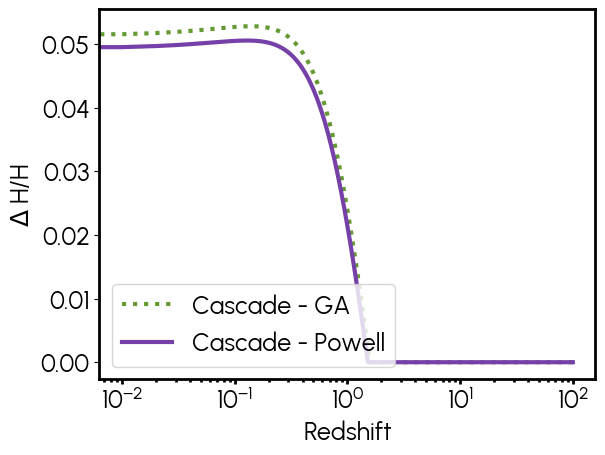

In [ ]:
DecayRate_Genetic_Alg = 5.18622651e-16 #Output from genetic algorithm parameter fit. 
zBreak_Genetic_Alg = 1.60875236e+00
FractionA_Genetic_Alg = 2.49856381e-01

DecayRate_Powell = 8.107024817779169e-16 #Output from grid search + Powell's method parameter fit. 
zBreak_Powell = 1.536942119410283
FractionA_Powell = 0.24955692834106383

#Here I apply a cubic spline interpolation, useful for plotting things below.
import scipy
#Note that np.flip is used becuase the interpolator will throw an error if you feed it a list of z-values that goes from large numbers to small ones. 
Interpolated_H_No_EDM=scipy.interpolate.CubicSpline(np.flip(zList_No_EDM), np.flip(HList_No_EDM), axis=0, extrapolate=None)

print('With Values From Genetic Algorithm Fit: ')
Interpolated_H_EDM_Genetic_Alg = ExoticDarkMatter(DecayRate_Genetic_Alg, zBreak_Genetic_Alg, FractionA_Genetic_Alg)[3]
print('With Values From Powell Algorithm Fit: ')
Interpolated_H_EDM_Powell = ExoticDarkMatter(DecayRate_Powell, zBreak_Powell, FractionA_Powell)[3]

zList=np.linspace(0, 100, 10000) #Redshifts between 0 and 100, for plotting 
zList=np.flip(zList)
deltaH_H_Genetic_Alg = (Interpolated_H_EDM_Genetic_Alg(zList) - Interpolated_H_No_EDM(zList))/Interpolated_H_No_EDM(zList) #Fractional change in H(z) as compared to Lambda-CDM.
deltaH_H_Powell = (Interpolated_H_EDM_Powell(zList) - Interpolated_H_No_EDM(zList))/Interpolated_H_No_EDM(zList)
#This is the Hubble parameter with EDM (i.e. with our cascade) minus the Hubble parameter in Lambda-CDM (no EDM/cascade) divided by H in Lambda-CDM.

#Plotting fractional change in H(z) 
plt.plot(zList, deltaH_H_Genetic_Alg, color=cmap(6), linestyle='dotted', linewidth = 3, label='Cascade - GA')
plt.plot(zList, deltaH_H_Powell, color=cmap(1), linewidth = 3, label='Cascade - Powell')
plt.xlabel("Redshift")
plt.ylabel(r'$\Delta$ H/H')
plt.xscale("log")
plt.legend(loc='lower left')
#plt.savefig('Symmetry_Breaking_Delta_H_Over_H.pdf')
plt.show()


Text(0.5, 1.0, 'Measured $\\rm{H}(z)/(1+z)$ Alongside Cascade')

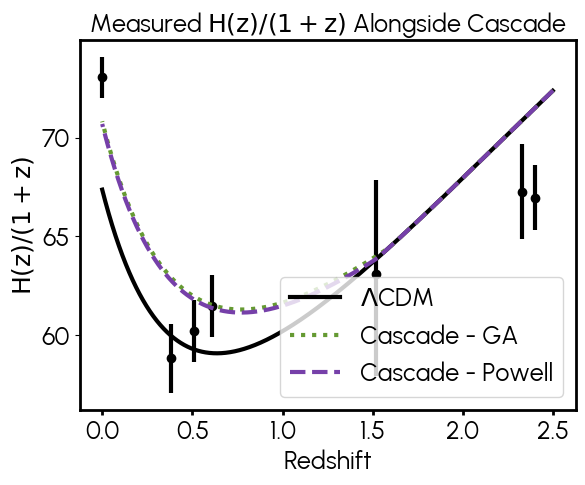

In [ ]:
z_0_2p5 = np.linspace(0, 2.5, 1000)
z_0_2p5 = np.flip(z_0_2p5)

Interpolated_H_EDM_1pz_Genetic_Alg = []
Interpolated_H_EDM_1pz_Powell = []
for element in z_0_2p5:
    Interpolated_H_EDM_1pz_Genetic_Alg.append(Interpolated_H_EDM_Genetic_Alg(element)/(1+element)) #H(z) / (1+z), useful for plotting.
    Interpolated_H_EDM_1pz_Powell.append(Interpolated_H_EDM_Powell(element)/(1+element))
    
plt.scatter(H_Measured_Redshift, H_Measured_1pz, color='k')
plt.vlines(x = H_Measured_Redshift, ymin = H_Measured_1pz - H_Measured_Uncertainty_Lower_1pz, ymax = H_Measured_1pz + H_Measured_Uncertainty_Upper_1pz, linewidth=3, colors = 'black')
plt.plot(zList_No_EDM[-2500:-1], H1pzList_No_EDM[-2500:-1], linewidth = 3, color='k', label=r'$Λ$CDM')
plt.plot(z_0_2p5, Interpolated_H_EDM_1pz_Genetic_Alg, linewidth = 3, linestyle = 'dotted', color=cmap(6), label=r'Cascade - GA')
plt.plot(z_0_2p5, Interpolated_H_EDM_1pz_Powell, linewidth = 3, linestyle = 'dashed', color=cmap(1), label=r'Cascade - Powell')
plt.xlabel('Redshift')
plt.ylabel(r'$\rm{H}(z)/(1+z)$')
plt.legend(loc='lower right')
plt.title(r'Measured $\rm{H}(z)/(1+z)$ Alongside Cascade')